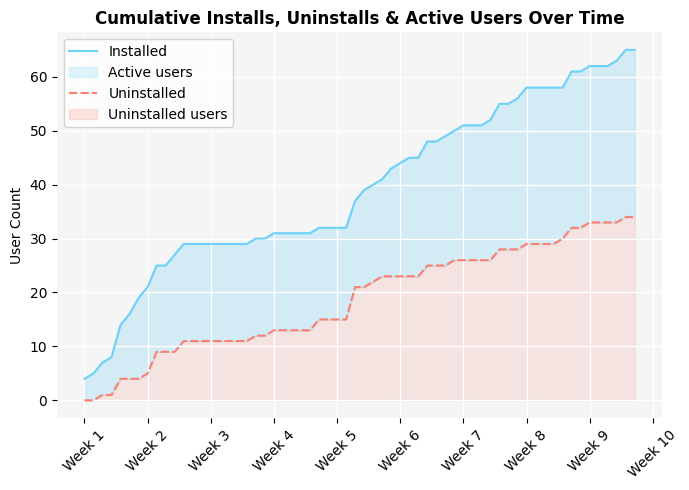

In [ ]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')


colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Convert created_at to datetime (if not already)
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')
df = df.sort_values('created_at')
df = df[df['created_at'] <= pd.to_datetime('2025-05-28', utc=True)]
df['date'] = df['created_at'].dt.date

# Keep only the first event seen by every user (install event)
df_installs = df.groupby('user_id', as_index=False).first()
df_installs['install'] = 1

# Get uninstall events
df_uninstall = df[df['type'] == 'uninstall'].copy()
df_uninstall['uninstall'] = 1

# Group by date and sum, then create a complete date range
df_installs_daily = df_installs.groupby('date')['install'].sum()
df_uninstall_daily = df_uninstall.groupby('date')['uninstall'].sum()

# Create a complete date range from min to max date
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# Reindex both series to include all dates, filling missing values with 0
df_installs_complete = df_installs_daily.reindex(date_range, fill_value=0)
df_uninstall_complete = df_uninstall_daily.reindex(date_range, fill_value=0)

# Now calculate cumulative sums
df_installs_cumsum = df_installs_complete.cumsum()
df_uninstall_cumsum = df_uninstall_complete.cumsum()

# Combine into final dataframe
accum = pd.DataFrame({
    'install': df_installs_cumsum,
    'uninstall': df_uninstall_cumsum
})


import matplotlib.dates as mdates
# Convert dates to datetime for week calculation
dates = pd.to_datetime(df['date'])

# Calculate week number relative to the first date, then extend by one week
min_date = dates.min()
max_date = dates.max()
num_weeks = ((max_date - min_date).days // 7) + 1

# Extend by one additional week
extended_num_weeks = num_weeks + 1
extended_week_ends = [min_date + pd.Timedelta(days=7 * i) for i in range(extended_num_weeks + 1)]

# Plot
plt.figure(figsize=(7, 5))

# Set xticks at the start of each week, including the extra week
plt.xticks(
    extended_week_ends,
    [f"Week {i + 1}" for i in range(extended_num_weeks + 1)],
    rotation=45
)
           
ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Plot the lines
sns.lineplot(data=accum, palette=['#6ED1F8', 'salmon'])

# Fill between installed and uninstalled (active users) with blue
ax.fill_between(accum.index, accum['install'], accum['uninstall'], 
                where=(accum['install'] > accum['uninstall']),
                color='#6ED1F8', alpha=0.25, label='Active Users')

# Fill below uninstalled with red
ax.fill_between(accum.index, 0, accum['uninstall'], 
                color='salmon', alpha=0.15, label='Uninstalled Users')
plt.title('Cumulative Installs, Uninstalls & Active Users Over Time', fontweight='bold')
plt.ylabel('User Count')
plt.xlabel(None)
plt.legend(['Installed', 'Active users', 'Uninstalled', 'Uninstalled users'], loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('./plots/accumulated_installs_uninstalls.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# For each day in the dataset, calculate the amount of active users. Proceed to the max amount of active users, mean and min
accum["active"] = accum["install"] - accum["uninstall"]
# Filter the dataframe for dates after 2025-04-02

max_active = accum['active'].max()
mean_active = accum['active'].mean()
min_active = accum['active'].min()

print(f"Max Active Users: {max_active}")
print(f"Mean Active Users: {mean_active}")
print(f"Min Active Users: {min_active}")



Max Active Users: 31
Mean Active Users: 20.580645161290324
Min Active Users: 4
